In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
import os
os.chdir("/content/drive/MyDrive/")

In [5]:
import csv
import re

import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm

# Educational Content: Indian vs The World

Are Indian people devoted into making educational videos?

In [6]:
df_channel_edu = pd.read_csv('edu-data/education_channel_with_country.csv')
df_channel_other = pd.read_csv('edu-data/other_channel_with_country.csv')

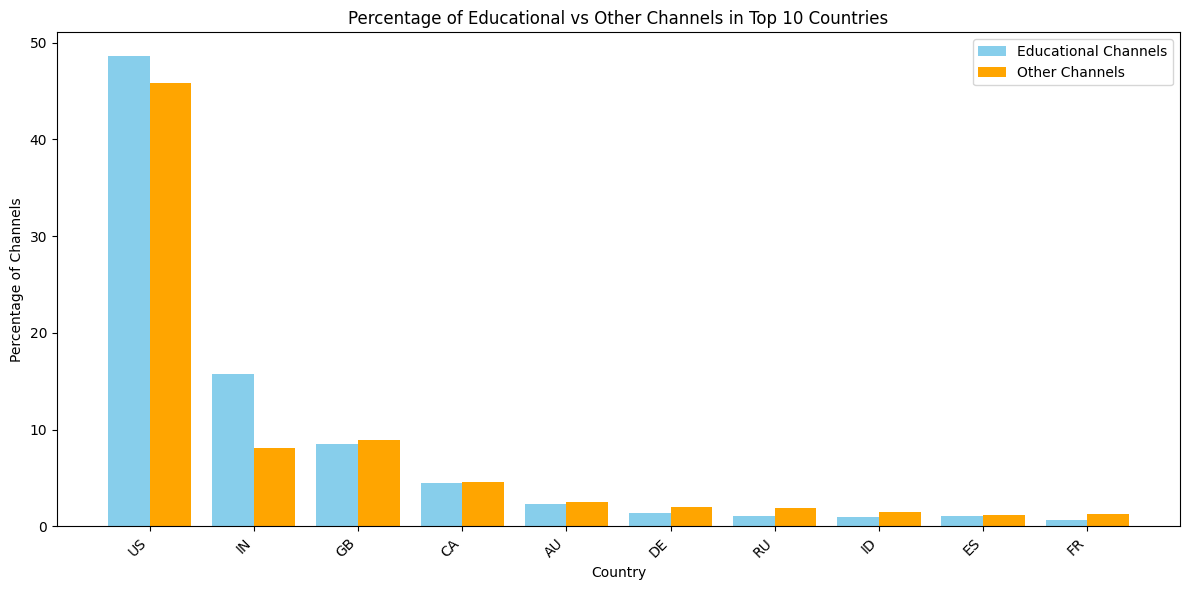

In [7]:
# Calculate the percentage of educational channels and other channels for each country
edu_country_counts = df_channel_edu['country'].value_counts(normalize=True) * 100
other_country_counts = df_channel_other['country'].value_counts(normalize=True) * 100

# Find the top 10 countries based on total percentage
total_counts = edu_country_counts.add(other_country_counts, fill_value=0)
top_10_countries = total_counts.nlargest(10).index

# Create data for the plot
edu_percentages = []
other_percentages = []

for country in top_10_countries:
    edu_percentage = edu_country_counts.get(country, 0)
    other_percentage = other_country_counts.get(country, 0)

    edu_percentages.append(edu_percentage)
    other_percentages.append(other_percentage)

# Create the bar chart with side-by-side bars
data = {'country': top_10_countries, 'edu_percentage': edu_percentages, 'other_percentage': other_percentages}
df_plot = pd.DataFrame(data)

plt.figure(figsize=(12, 6))

x = range(len(top_10_countries))
width = 0.4

plt.bar([i - width/2 for i in x], df_plot['edu_percentage'], width=width, label='Educational Channels', color='skyblue')
plt.bar([i + width/2 for i in x], df_plot['other_percentage'], width=width, label='Other Channels', color='orange')

plt.xlabel('Country')
plt.ylabel('Percentage of Channels')
plt.title('Percentage of Educational vs Other Channels in Top 10 Countries')
plt.xticks(x, top_10_countries, rotation=45, ha='right')
plt.legend()
plt.tight_layout()
plt.show()

The US and most other countries show minimal differences in the distribution between education and other categories. However, India stands out with a notably higher proportion of education channels compared to other types.

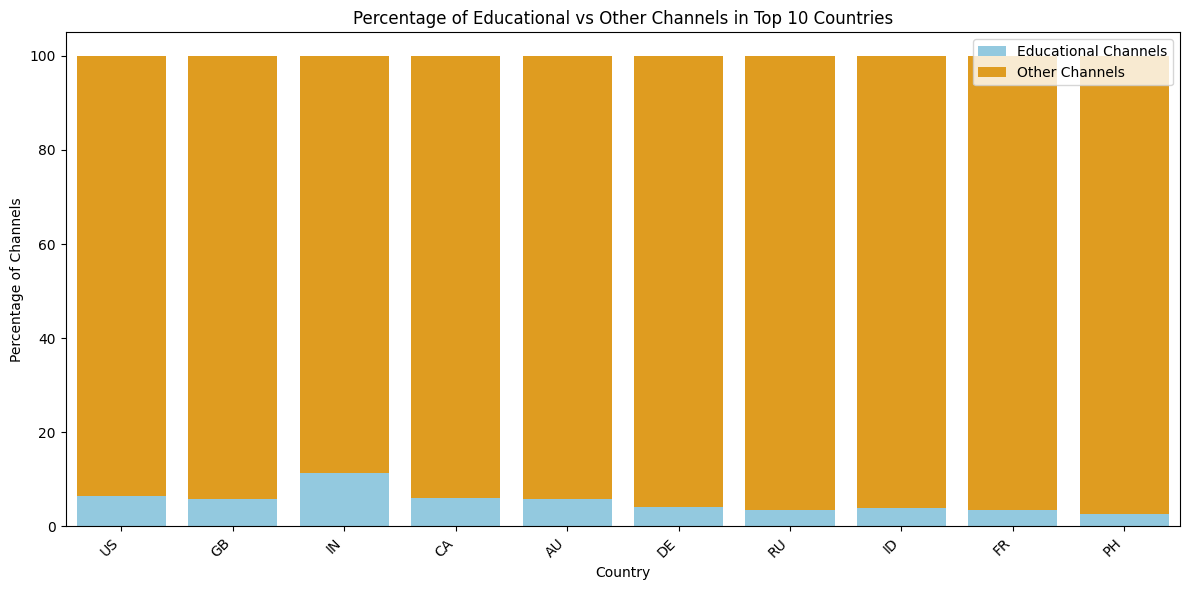

In [11]:
# Calculate the percentage of educational channels and other channels for each country
edu_country_counts = df_channel_edu['country'].value_counts()
other_country_counts = df_channel_other['country'].value_counts()

# Find the top 10 countries based on total channel counts
total_counts = edu_country_counts.add(other_country_counts, fill_value=0)
top_10_countries = total_counts.nlargest(10).index

# Create data for the plot
data = []
for country in top_10_countries:
    edu_count = edu_country_counts.get(country, 0)
    other_count = other_country_counts.get(country, 0)
    total_count = edu_count + other_count

    # Calculate percentages
    edu_percentage = (edu_count / total_count) * 100 if total_count > 0 else 0
    other_percentage = (other_count / total_count) * 100 if total_count > 0 else 0

    data.append({'country': country, 'edu_percentage': edu_percentage, 'other_percentage': other_percentage})

# Convert to DataFrame
df_plot = pd.DataFrame(data)

# Plot the stacked bar chart
plt.figure(figsize=(12, 6))
sns.barplot(x='country', y='edu_percentage', data=df_plot, color='skyblue', label='Educational Channels')
sns.barplot(x='country', y='other_percentage', data=df_plot, color='orange', label='Other Channels', bottom=df_plot['edu_percentage'])

# Customize the plot
plt.xlabel('Country')
plt.ylabel('Percentage of Channels')
plt.title('Percentage of Educational vs Other Channels in Top 10 Countries')
plt.xticks(rotation=45, ha='right')
plt.legend()
plt.tight_layout()
plt.show()

The figure shows the top 10 countries based on percentage of all channel counts.
India (IN) has a higher percentage of educational content compared to other countries even though.

## Many people say... When studying STEM, no matter how hard or how strange a subject is, there's always an Indian Tutor on YouTube to help us pass our exams. Really?

# Now let's take a look at the trend for STEM content...

In [13]:
# Load STEM-categorized education video data
df_stem_videos = pd.read_csv('data-final/stem_videos_final.csv')

In [16]:
df_videos = pd.read_csv('edu-data/video_with_stem_titles_and_cutoffs20.csv')

In [14]:
df_stem_videos.sample(10)

,categories,channel_id,crawl_date,dislike_count,display_id,duration,like_count,tags,title,upload_date,view_count,name_cc,subscribers_cc,country,is_stem_title,title_matched_keywords,is_stem_tags,tag_matched_tags,tag_matched_keywords
42518,Education,UCS3wWlfGUijnRIf745lRl2A,2019-11-16 20:41:58.223942,1.0,nADXMU7mrUk,238,49.0,"science,biology,learn,revision,GCSE,AQA,high s...",Ecosystem Management | Ecology & Environment |...,2016-08-01 00:00:00,7191.0,FuseSchool - Global ...,259000.0,GB,True,ecology,True,"biodiversity, ecology","biodiversity, ecology"
4013,Education,UCuSp8zRQslAciU1kYkyl3mA,2019-11-08 05:43:50.095225,0.0,15dUkF0B0Cs,281,31.0,"Matrix,Bangla Lecture,BBA Honours,Accounting,M...","Matrix, ম্যাট্রিক্স , Bangla Lecture for BBA H...",2019-09-28 00:00:00,968.0,Online Education BD,21700.0,IN,True,matrix,True,"Finance And Banking, Matrix","finance, matrix"
50151,Education,UCLJiSMXJ9K-1AOTqIqdXJgQ,2019-11-21 21:23:32.955104,0.0,6ktXVSjipY4,1074,1.0,"tastytrade,tastytrade.com,tasty trade,tastytra...",Tom Kuczmarski & Luke Tanen of Chicago Innovat...,2014-03-28 00:00:00,1062.0,tastytrade,132000.0,US,True,innovation,True,"finance, innovation","finance, innovation"
34797,Education,UCZzatyx-xC-Dl_VVUVHYDYw,2019-11-18 14:40:54.361180,1.0,qPSKMrt72dk,224,15.0,"Sixty,Symbols,Minutephysics,veritasium,gcse,sc...",Edexcel Physics Paper 1 (AS) 2016 | Question 10,2017-09-21 00:00:00,1213.0,GCSE and A Level Phy...,56600.0,GB,True,physics,True,"Physics, physics",physics
69934,Education,UC4dRrh0BquGQ-uc4F1_y_2g,2019-11-08 05:29:33.225123,4.0,89WOTC_fAVQ,277,61.0,"Wound Care,Wound,Care,Wounds,Medical Education...",WCW: Treating Frostbite using Near Infrared Sp...,2019-02-13 00:00:00,1266.0,WebCME,31100.0,US,True,spectroscopy,True,spectroscopy,spectroscopy
34052,Education,UC_ABJRhYn_W-atwn8o4OKjQ,2019-11-08 06:16:16.906727,0.0,XTf6UOPyEho,452,6.0,"YouTube,Calculus: 2nd Derivative Test for Conc...",Calculus: 2nd Derivative Test for Concavity an...,2014-01-11 00:00:00,483.0,Numberbender,100000.0,PH,True,"calculus, derivative",True,Calculus: 2nd Derivative Test for Concavity an...,"calculus, derivative"
599,Education,UCzgQ5QtO8zf1K7E-Xc5T_zA,2019-11-22 07:05:08.603523,0.0,sQGXOP_q3TM,463,4.0,"Fleming's left-hand rule,Magnetic effect of el...",Fleming's left-hand rule || Magnetic effect of...,2019-01-24 00:00:00,504.0,Open Mind,31200.0,IN,True,physics,True,"online physics classes 10, physics cbse and nc...","classes, physics"
39989,Education,UCUdgDNPGYCRJraG3BGxF2UA,2019-11-12 20:10:07.738633,4.0,g9LFMT7pFfA,270,27.0,"Dell,laptop,repair,tutorial,how-to,installatio...",Dell Inspiron 17 (7737) Coin Cell CMOS Battery...,2015-01-23 00:00:00,8471.0,"Parts-People.Com, In...",43600.0,US,True,cmos,True,CMOS Battery,cmos
27478,Education,UCc5FkTYiWH5L3Gk5IyW6Rmw,2019-11-19 19:42:40.573856,7.0,R5BDSRJ_dWQ,549,176.0,"javascript tutorial,javascript tutorial for be...",Array in JavaScript (Hindi),2018-07-25 00:00:00,13478.0,Geeky Shows,206000.0,IN,True,javascript,True,"javascript interview questions and answers, ja...",javascript
32968,Education,UCaiJlKxXamoODQtlx486qJA,2019-11-18 22:24:51.705341,NaN,jnxTpxB7HR8,4767,NaN,"digital signal processing,rich radke,radke,dsp...",DSP Lecture 10: The Discrete Fourier Transform,2014-09-29 00:00:00,41829.0,Rich Radke,22000.0,US,True,discrete fourier transform,True,Discrete Fourier Transform,discrete fourier transform


<ipython-input-17-784cb8ed2c5f>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  top_10_countries["total_percentage"] = (top_10_countries["count"] / len(df_videos)) * 100


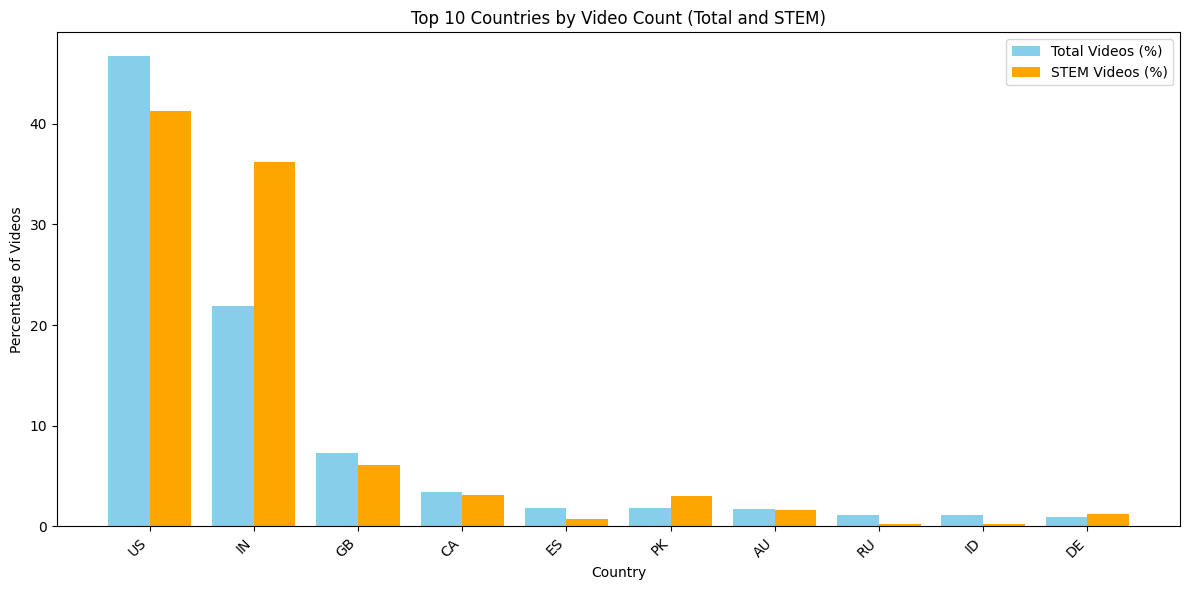

In [17]:
# Group by country and count videos
country_counts = df_videos.groupby("country").size().reset_index(name='count').sort_values('count', ascending=False)

# Get the top 10 countries
top_10_countries = country_counts.head(10)

# Calculate relative percentages
top_10_countries["total_percentage"] = (top_10_countries["count"] / len(df_videos)) * 100

# Similarly, use pandas methods for stem_country_counts
stem_country_counts = df_stem_videos.groupby("country").size().reset_index(name='count').sort_values('count', ascending=False)

# Merge dataframes (no change needed here)
top_10_countries = pd.merge(top_10_countries, stem_country_counts, on="country", how="left", suffixes=("_total","_stem"))
top_10_countries["stem_percentage"] = (top_10_countries["count_stem"] / len(df_stem_videos)) * 100
top_10_countries.fillna(0, inplace=True)

# Plotting
plt.figure(figsize=(12, 6))

bar_width = 0.4

# Total Video Percentage
plt.bar(np.arange(len(top_10_countries)), top_10_countries["total_percentage"], width=bar_width, label="Total Videos (%)", color='skyblue')

# STEM Video Percentage
plt.bar(np.arange(len(top_10_countries)) + bar_width, top_10_countries["stem_percentage"], width=bar_width, label="STEM Videos (%)", color='orange')


plt.xlabel("Country")
plt.ylabel("Percentage of Videos")
plt.title("Top 10 Countries by Video Count (Total and STEM)")
plt.xticks(np.arange(len(top_10_countries)) + bar_width / 2, top_10_countries["country"], rotation=45, ha="right")
plt.legend()
plt.tight_layout()
plt.show()

From the above graph, it seems like the US and India has the significance of STEM Videos percentage compared to others. Let's take a deeper look into this:

In [18]:
# Convert the 'upload_date' column to datetime objects
df_stem_videos['upload_date'] = pd.to_datetime(df_stem_videos['upload_date'], format="%Y-%m-%d %H:%M:%S")

# Extract the year from the 'upload_date'
df_stem_videos['upload_year'] = df_stem_videos['upload_date'].dt.year

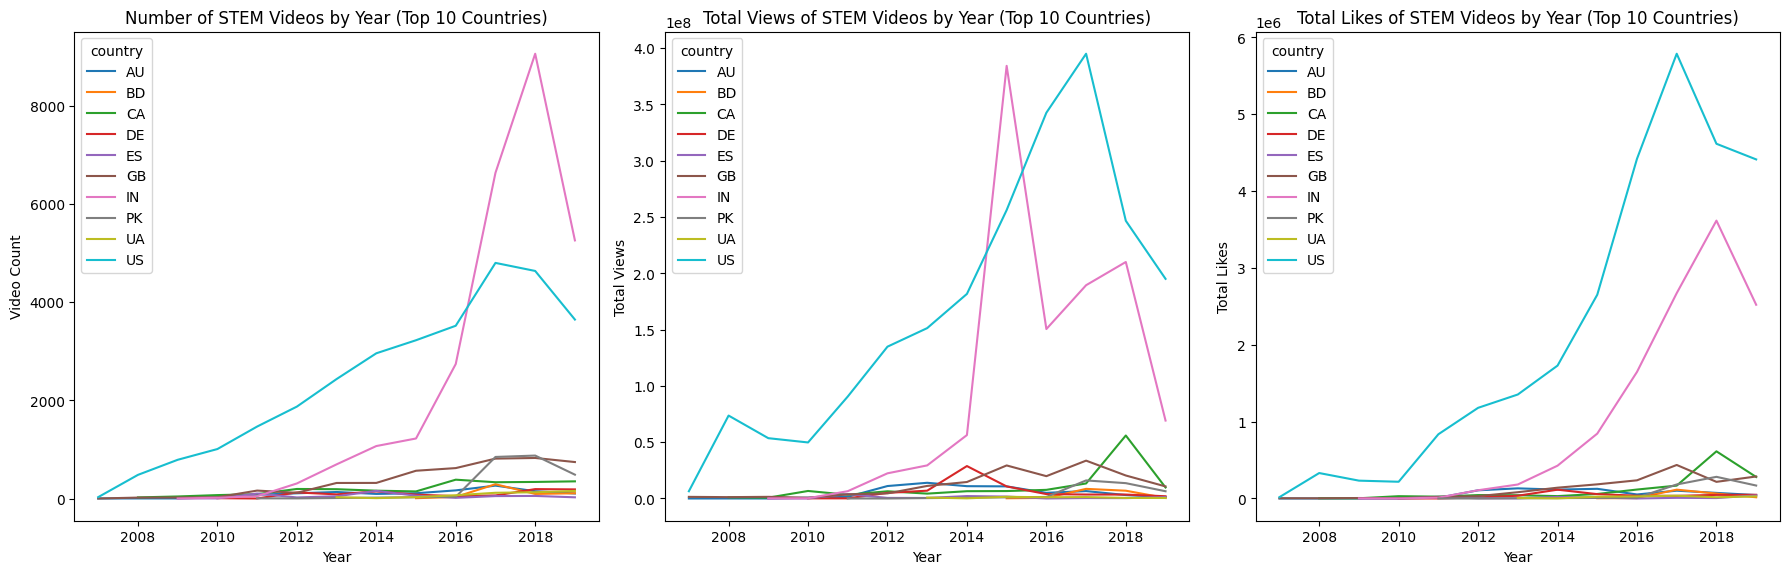

In [19]:
# Group data by country and year
grouped_data = df_stem_videos.groupby(["country", "upload_year"]).agg(
    video_count=("upload_year", "size"),
    total_views=("view_count", "sum"),
    total_likes=("like_count", "sum")
).reset_index()

# Get the top 10 countries with the most STEM videos
stem_country_counts = grouped_data.groupby("country")["video_count"].sum().reset_index()
stem_country_counts = stem_country_counts.rename(columns={"video_count": "count"})
top_10_countries = stem_country_counts.sort_values("count", ascending=False).head(10)
top_10_countries_list = top_10_countries["country"].tolist()

# Filter data for the top 10 countries
top_10_df = grouped_data[grouped_data["country"].isin(top_10_countries_list)]

# Plotting
plt.figure(figsize=(18, 6))

# Setting the hue order
sorted_countries = sorted(top_10_df['country'].unique())

# Video count
plt.subplot(1, 3, 1)
sns.lineplot(x="upload_year", y="video_count", hue="country", hue_order=sorted_countries, data=top_10_df)
plt.title("Number of STEM Videos by Year (Top 10 Countries)")
plt.xlabel("Year")
plt.ylabel("Video Count")

# View count
plt.subplot(1, 3, 2)
sns.lineplot(x="upload_year", y="total_views", hue="country", hue_order=sorted_countries, data=top_10_df)
plt.title("Total Views of STEM Videos by Year (Top 10 Countries)")
plt.xlabel("Year")
plt.ylabel("Total Views")

# Like count
plt.subplot(1, 3, 3)
sns.lineplot(x="upload_year", y="total_likes", hue="country", hue_order=sorted_countries, data=top_10_df)
plt.title("Total Likes of STEM Videos by Year (Top 10 Countries)")
plt.xlabel("Year")
plt.ylabel("Total Likes")

plt.tight_layout()
plt.show()

The United States and India are the leading contributors to STEM video production, views, and engagement. The US emerged early as the dominant player in STEM content, with steady growth in video production, views, and likes. In contrast, India experienced a rapid and aggressive rise starting around 2014, significantly increasing production, viewership, and engagement. Notably, Indian creators surpassed US viewership between 2014 and 2016 before experiencing a decline. Despite India’s surge, the US maintains higher overall engagement, consistently outperforming other countries in total likes and sustaining strong viewership trends.

This highlights the US’s long-standing dominance and India’s rapid growth in the STEM content landscape. Though is this growth stable?

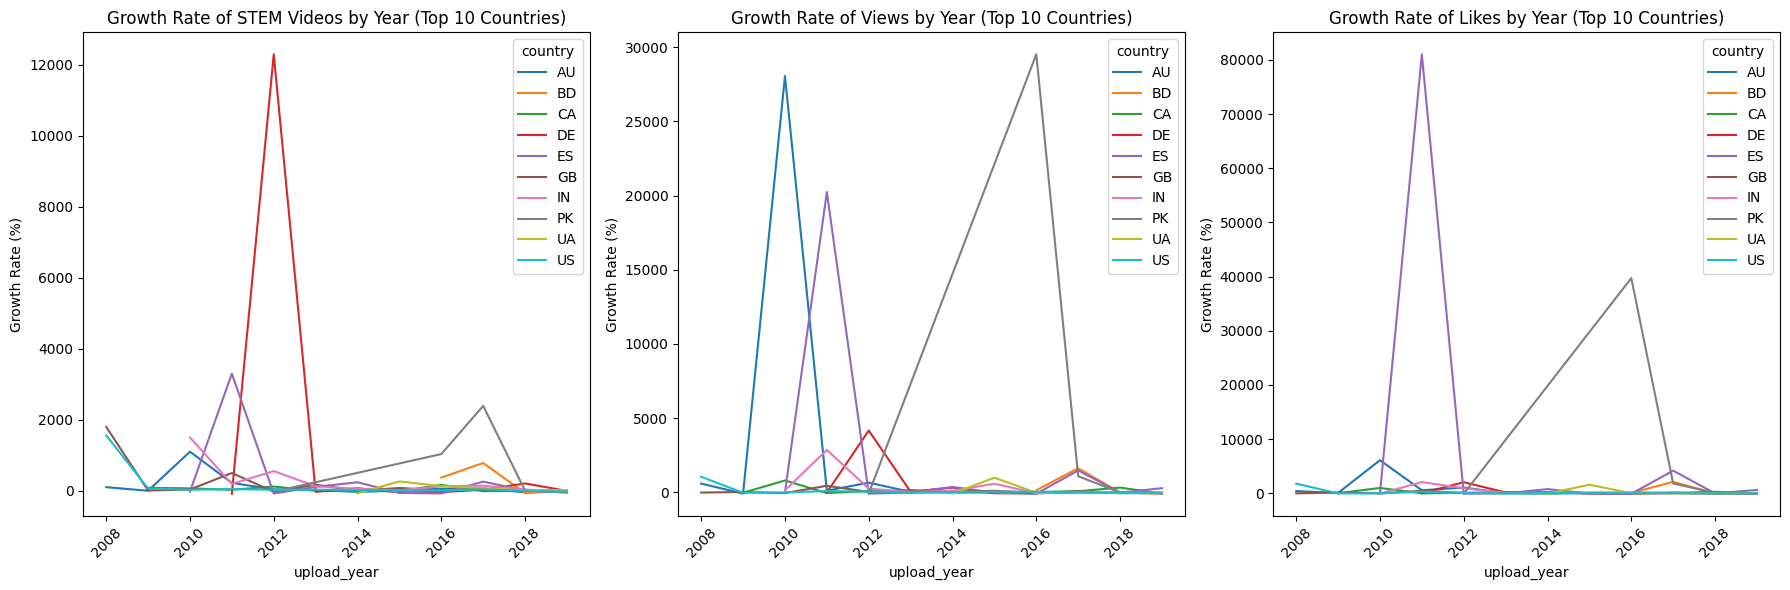

In [21]:
# Calculate year-over-year percentage change
def calculate_growth_rate(df, group_by, column, new_column_name):
    df_sorted = df.sort_values([group_by, 'upload_year'])
    df[new_column_name] = df.groupby(group_by)[column].pct_change() * 100
    return df

# Create a copy to avoid overwriting the original dataframe
top_10_growth_df = top_10_df.copy()

# Apply the function to calculate growth rates
top_10_growth_df = calculate_growth_rate(top_10_growth_df, 'country', 'video_count', 'video_growth_rate')
top_10_growth_df = calculate_growth_rate(top_10_growth_df, 'country', 'total_views', 'views_growth_rate')
top_10_growth_df = calculate_growth_rate(top_10_growth_df, 'country', 'total_likes', 'likes_growth_rate')

# Plotting
plt.figure(figsize=(18, 6))

# Number of videos growth rate
plt.subplot(1, 3, 1)
sns.lineplot(x="upload_year", y="video_growth_rate", hue="country", hue_order=sorted_countries, data=top_10_growth_df)
plt.title("Growth Rate of STEM Videos by Year (Top 10 Countries)")
plt.xticks(rotation=45)
plt.ylabel("Growth Rate (%)")

# Total views growth rate
plt.subplot(1, 3, 2)
sns.lineplot(x="upload_year", y="views_growth_rate", hue="country", hue_order=sorted_countries, data=top_10_growth_df)
plt.title("Growth Rate of Views by Year (Top 10 Countries)")
plt.xticks(rotation=45)
plt.ylabel("Growth Rate (%)")

# Total likes growth rate
plt.subplot(1, 3, 3)
sns.lineplot(x="upload_year", y="likes_growth_rate", hue="country", hue_order=sorted_countries, data=top_10_growth_df)
plt.title("Growth Rate of Likes by Year (Top 10 Countries)")
plt.xticks(rotation=45)
plt.ylabel("Growth Rate (%)")

plt.tight_layout()
plt.show()


While other countries also had certain surges of STEM videos content creation at some point in time, they seem to eventually die down. India, on the other hand, while only witnessed a small peak around 2012, and but then keep growing at a stable rate.

In [27]:
df_stem_india = df_stem_videos[df_stem_videos['country'] == 'IN']
print(f"Total number of STEM videos from India: {len(df_stem_india)}")
df_stem_india_counts = df_stem_india['name_cc'].value_counts()
print(f"Number of unique STEM videos from India: {len(df_stem_india_counts)}")
df_stem_india_counts

Total number of STEM videos from India: 27049
Number of unique STEM videos from India: 472


,count
name_cc,
Doubtnut,3058
Ekeeda,2822
Durga Software Solut...,2420
Pradeep Kshetrapal,1149
Geeky Shows,1119
...,...
Tech Garden,1
Skill Bill : Tally G...,1
BV Pattabhiram,1


The data reveals a notable concentration of Indian content creators producing educational or STEM-related content, with 27049 videos of 74717 STEM-classified videos. Specifically:

Channels like DoubtNut (3058 videos), Ekeeda (2822 videos), and Durga Software Solutions (2420 videos) are among the most prolific.
472 unique content creators, indicating a wide range of contributors in the field. There are many smaller channels with just one video each, highlighting a long tail of niche creators.